In [34]:
#@title Download dataset of personal attacks from the [wiki detox datasets](https://meta.wikimedia.org/wiki/Research:Detox/Data_Release).

import pandas as pd
import urllib
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# download annotated comments and annotations

ANNOTATED_COMMENTS_URL = 'https://ndownloader.figshare.com/files/7554634'
ANNOTATIONS_URL = 'https://ndownloader.figshare.com/files/7554637'

def download_file(url, fname):
    urllib.request.urlretrieve(url, fname)

download_file(ANNOTATED_COMMENTS_URL, 'attack_annotated_comments.tsv')
download_file(ANNOTATIONS_URL, 'attack_annotations.tsv')
comments = pd.read_csv('attack_annotated_comments.tsv', sep = '\t', index_col = 0)
annotations = pd.read_csv('attack_annotations.tsv',  sep = '\t')
print(f"Successfully downloaded {len(comments)} comments and {len(annotations)} annotations.")
print("[TODO]: explore comments and annotations.")

Successfully downloaded 115864 comments and 1365217 annotations.
[TODO]: explore comments and annotations.


In [35]:
#@title Build a labeled dataset of personal attacks, from annotations.
# labels a comment as an attack if the majority of annotators did so
labels = annotations.groupby('rev_id')['attack'].mean() > 0.5
# join labels and comments
comments['attack'] = labels
# remove newline and tab tokens
comments['comment'] = comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
comments['comment'] = comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))
print(f"Built a labeled dataset of attacks, based on majority annotations. Sample of attacks:")
comments.query('attack')['comment'].head()

Built a labeled dataset of attacks, based on majority annotations. Sample of attacks:


rev_id
801279             Iraq is not good  ===  ===  USA is bad   
2702703      ____ fuck off you little asshole. If you wan...
4632658         i have a dick, its bigger than yours! hahaha
6545332      == renault ==  you sad little bpy for drivin...
6545351      == renault ==  you sad little bo for driving...
Name: comment, dtype: object

In [13]:
#@title Train a simple text classifier.

train_comments = comments.query("split=='train'")
test_comments = comments.query("split=='test'")

clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf', LogisticRegression()),
])
clf = clf.fit(train_comments['comment'], train_comments['attack'])
auc = roc_auc_score(test_comments['attack'], clf.predict_proba(test_comments['comment'])[:, 1])
print('Trained a binary classifier, with test set ROC AUC: %.3f' %auc)
print("[TODO]: What do these things mean? ngram_range, norm, confusion matrix, AUC")

Trained a binary classifier, with test set ROC AUC: 0.957
[TODO]: What do these things mean? ngram_range, norm, confusion matrix, AUC


In [14]:
#@title Testing the classifier on some new text.
nice_comment = "This is a good review!" #@param {type: "raw"}
nasty_comment = "You are stupid and an idiot!" #@param {type: "raw"}
clf.predict([nice_comment, nasty_comment])

array([False,  True])

In [17]:
#@title Download full unlabeled user-talk and article-talk 2004 corpus.
import os
import re
from scipy.stats import bernoulli
import seaborn as sns
import matplotlib.pyplot as plt

# download and untar data
USER_TALK_CORPUS_2004_URL = 'https://ndownloader.figshare.com/files/6982061'
ARTICLE_TALK_CORPUS_2004_URL = 'https://ndownloader.figshare.com/files/7038050'

download_file(USER_TALK_CORPUS_2004_URL, 'comments_user_2004.tar.gz')
download_file(ARTICLE_TALK_CORPUS_2004_URL,  'comments_article_2004.tar.gz')

os.system('tar -xzf comments_user_2004.tar.gz')
os.system('tar -xzf comments_article_2004.tar.gz')

# helper for collecting a sample of comments for a given ns and year from
def load_no_bot_no_admin(ns, year, prob = 0.1):
    dfs = []
    data_dir = "comments_%s_%d" % (ns, year)
    for _, _, filenames in os.walk(data_dir):
        for filename in filenames:
            if re.match("chunk_\d*.tsv", filename):
                df = pd.read_csv(os.path.join(data_dir, filename), sep = "\t")
                df['include'] = bernoulli.rvs(prob, size=df.shape[0])
                df = df.query("bot == 0 and admin == 0 and include == 1")
                dfs.append(df)
    sample = pd.concat(dfs)
    sample['ns'] = ns
    sample['year'] = year
    return sample

# collect a random sample of comments from 2004 for each namespace
corpus_user = load_no_bot_no_admin('user', 2004)
corpus_article = load_no_bot_no_admin('article', 2004)
corpus = pd.concat([corpus_user, corpus_article])

print("Downloaded random sample of comments from each corpus: user and article")
print("[TODO]: Explore the data")

Downloaded random sample of comments from each corpus: user and article
[TODO]: Explore the data


In [25]:
#@title Use our classifier to label these two datasets.
corpus['comment'] = corpus['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
corpus['comment'] = corpus['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))
corpus['attack'] = clf.predict_proba(corpus['comment'])[:,1] > 0.425 # why this threshold?
corpus.query("attack")["comment"].head()

1361    "**You, dude. You're the guy upset at vandals ...
3025       Please stop supporting  for adminship. He m...
6833                  You're welcome! You deserve it.    
8358         "  You're welcome, and enjoy your break.   "
8524                                   == you'r a dork ==
Name: comment, dtype: object

In [32]:
corpus.query("attack")["comment"].iloc[15]

'"  ==Crazy Shit== *People have bent over backwards to accomodate you, mostly out of a pure concern for fairness and justice. You have eroded all the good will left in my body. Any more crap out of you, and I will ""take steps"". Better listen up good, because I\'m one the oldest ""old hands"" around here and I know how to work the system. Don\'t get me riled up against you, or I will force you out!! (A word to the wise is sufficient.) Uncle Ed   **No matter how old you are, you don\'t have the authority to force anyone out unilaterally. This rhetoric just once again shows how unfit you are for sysophood. Wik   **Well; who would have thought we could ever; agree? Ed Poor is totally unfit. "'

Text(0.5, 0, 'Dataset type')

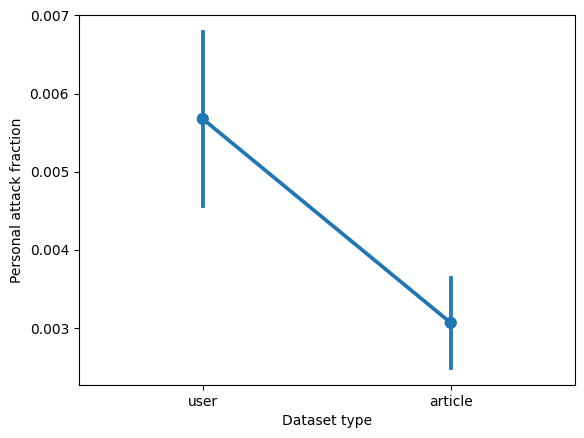

In [33]:
#@title Which corpus has more prevalence of personal attacks - user or article?
sns.pointplot(data = corpus, x = 'ns', y = 'attack')
plt.ylabel("Personal attack fraction")
plt.xlabel("Dataset type")

# Assignments

1. Use pre-trained Bertclassifier for personal attacks (keras_nlp).
2. Explore the word embeddings of top attack words.